In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot functions

In [15]:
import matplotlib.pyplot as plt

def plot_dataframe(dr):
    
    for index in dr.data_frame.index:

        units = dr.data_frame.loc[index]['Units']
        t = dr.data_frame.loc[index]['Times']
        x = dr.data_frame.loc[index,'Domains']
        y = dr.data_frame.loc[index]['Values']
        s = y.shape

        if not x and len(y)>1:
            plt.figure(figsize=(10,5))
            plt.title("Trend - " + index)
            plt.plot(t/(24*3600), y, c='b')
            plt.plot(t/(24*3600), y, c='r')
            plt.ylabel("{0} ({1})".format(index,units))
            plt.xlabel('Time (day)')

        if x and s[1]>1:

            x = x[0]
            nt = t.size-1
            nx = x.size-1

            fig,(ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
            ax1.plot(t/(24*3600), y[:,0], c='b', label="inlet")
            ax1.plot(t/(24*3600), y[:,nx], c='r', label="outlet")
            label = ax1.set_xlabel('Time (day)')
            label = ax1.set_ylabel("{0} ({1})".format(index,units))
            legend = ax1.legend(loc='upper center', shadow=True, fontsize='x-large')

            ax2.plot(x, y[0,:], c='b', label='initial')
            ax2.plot(x, y[nt,:], c='r', label='final')
            label = ax2.set_xlabel('Position (-)')
            label = ax2.set_ylabel("{0} ({1})".format(index,units))
            legend = ax2.legend(loc='upper right', shadow=True, fontsize='x-large')

## Example 1 - biofilm formation with constant fluid velocity

This is a very simplified model where the biofilm formation does not have any influence of the hydraulics. The purpose is to check the formation of the biofilm with constant fluid velocity and temperature.

### Preparing data

In [16]:
from daetools.pyDAE import *
from daetools.pyDAE.data_reporters import daePandasDataReporter
from daetools_extended.daesimulation_extended import daeSimulationExtended

data = {
    'name': 'biofilm_test_01',
    'kind': 'biofilm',
    'module': 'models.biofilm',
    'class': 'Biofilm',
    'submodels': {
    },
    'specifications': {
        'Tbf': 273.15 + 37,
        'vbf': 0.54,
    },
    'parameters': {
        'rhomf': 980,
        'mfi': 1e-6,
    },
    'initial_guess': {
        'mf': 1e-6,
    }
}

### Executing simulation

In [17]:
# Instantiate
cfg = daeGetConfig()
cfg.SetBoolean('daetools.activity.printHeader', False)
simulation = daeSimulationExtended("", data=data, set_reporting = True, reporting_interval = 3600*6, time_horizon = 3600*24*20)
dr = daePandasDataReporter()
solver = daeIDAS()
solver.RelativeTolerance = 1e-9
log = daePythonStdOutLog()
# Initialize
simulation.Initialize(solver, dr, log)
# Solve at time = 0
simulation.SolveInitial()
# Run
simulation.Run()
# Clean up
simulation.Finalize()

Creating the system...        
Tbf 1% ETA: [00.0s]
vbf 1
The system created successfully in: 0.003 s
 0.00% ETA: [00.0s]Starting the initialization of the system... Done.
 0.00% ETA: [00.0s]Integrating from [0] to [21600] ...
 0.00% ETA: [00.0s]Integrating from [21600] to [43200] ...
 2.00% ETA: [01.1s]Integrating from [43200] to [64800] ...
 3.00% ETA: [00.8s]Integrating from [64800] to [86400] ...
 4.00% ETA: [00.6s]Integrating from [86400] to [108000] ...
 5.00% ETA: [00.6s]Integrating from [108000] to [129600] ...
 7.00% ETA: [00.6s]Integrating from [129600] to [151200] ...
 8.00% ETA: [00.6s]Integrating from [151200] to [172800] ...
 9.00% ETA: [00.5s]Integrating from [172800] to [194400] ...
 10.00% ETA: [00.5s]Integrating from [194400] to [216000] ...
 12.00% ETA: [00.4s]Integrating from [216000] to [237600] ...
 13.00% ETA: [00.4s]Integrating from [237600] to [259200] ...
 14.00% ETA: [00.4s]Integrating from [259200] to [280800] ...
 15.00% ETA: [00.4s]Integrating from [280800]

### Ploting

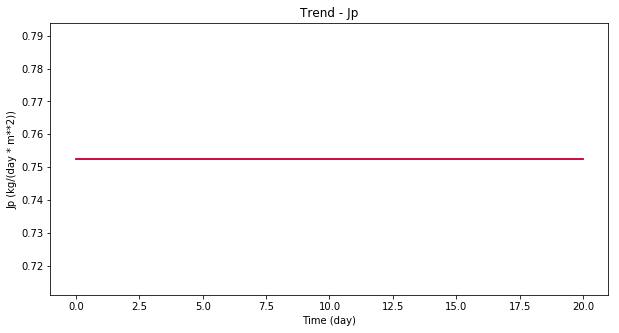

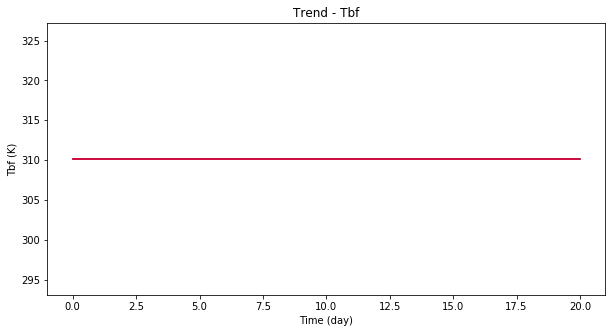

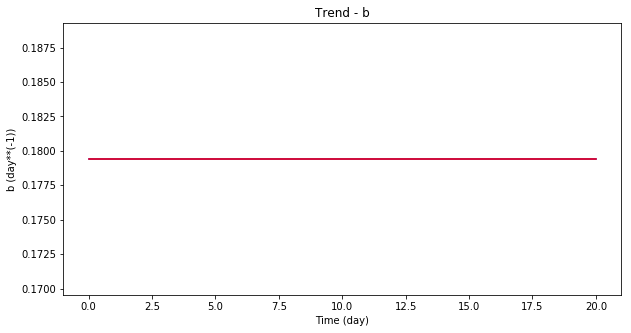

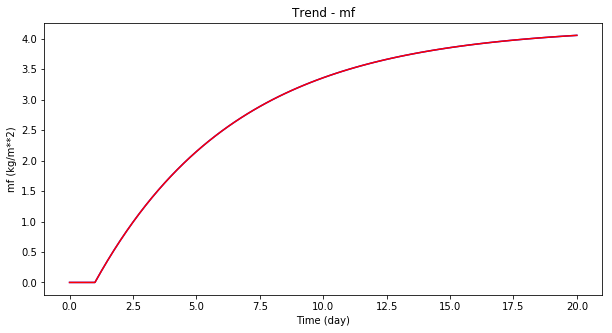

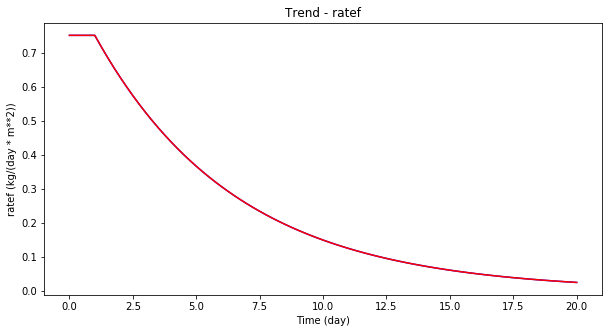

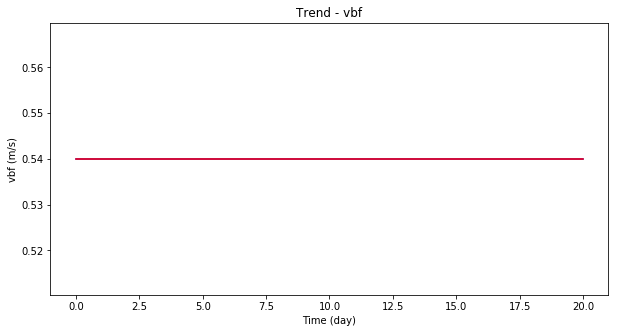

In [18]:
plot_dataframe(dr)

## Example 2 - Biofilm formation inside a condenser tube

This example considers all heat exchange and fluidynamics phenomena. The biofilm grows and influences the overall heat exchange coefficient and also impacts the flow rate of the cooling water. We assume fixed upstream and downstream pressures. The external convection coefficient is calculated assuming that the tube is isolated (without the influence of other tubes of the condenser.

### Preparing data

In [19]:
from daetools.pyDAE import *
from models.biofilmed_external_film_cond_pipe import *
from daetools.pyDAE.data_reporters import daePandasDataReporter
from water_properties import density, heat_capacity, conductivity, viscosity
from daetools_extended.daesimulation_extended import daeSimulationExtended

p1 = 414553 - 12814 #Pa
p2 = 384385 + 12814 + 750 #Pa
t1 = 305.15
t2 = 315.63

p1t = p1 - 45
p2t = p2 + 45

q = 0.10425

Pm = 0.5 * (p1t + p2t)
Tm = 0.5 * (t1 + t2)

data = {
    'name': 'network_test_01',
    'kind': 'network',
    'submodels': {
        'node_A': {
            'kind': 'node',
            'module': 'models.source',
            'class': 'Source',
            'specifications': {
                'P': p1,
            },
            'parameters': {
                'Text': t1,
                'Pext': p1,
                'x': 0.0,
                'y': 0.0,
                'z': 0.0
            },
            'initial_guess': {
                'w': q,
                'T': t1,
                'P': p1,
            }
        },
        'node_B': {
            'kind': 'node',
            'module': 'models.sink',
            'class': 'Sink',
            'specifications': {
                'P': p2,
            },
            'parameters': {
                'Text': t2,
                'Pext': p2,
                'x': 0.0,
                'y': 1.0,
                'z': 0.0
            },
            'initial_guess': {
                'w': q,
                'T': t2,
                'P': p2,
            }
        },
        'pipe_01': {
            'kind': 'edge',
            'module': 'models.biofilmed_external_film_cond_pipe',
            'class': 'BiofilmedExternalFilmCondPipe',
            'from': 'node_A',
            'to': 'node_B',
            'domains': {
                'N': 20,
            },
            'states': {
                'stnWaterPropertiesSetup': 'Variable',  # Variable or Fixed
                'stnFlowRegimeSetup': 'Turbulent',  # Laminar, Turbulent or Calculated
            },
            'parameters': {
                'Di': 0.01575,
                'Do': 0.01905,
                'kwall': 16.0,
                'tetha': 0.0,
                'L': 6.1,
                'ep': 45e-6,
                'Klb': 0.5 * 0.9,
                'Kub': 0.5 * 0.9,
                'Npipes': 1.0,
                'rhov': 0.06560,
                'hvap': 2393988,
                'Tsat': 45.01 + 273.15,
                'Psat': 9600,
                'fNtub': 1.0,
                'rhomf': 980.,
                'mfi': 1e-6,
            },
            'specifications': {
                #'mf': 0.000001
            },
            'initial_guess': {
                'Re': 12187,
                'D': 0.01575,
                'v': 0.54,
                'k': q,
                'T': [t1, t2],
                'P': [p1t, p2t],
                'fD': 0.0337,
                'dp': 310.0,
                'kappa': conductivity(Tm, Pm, simplified=True),
                'cp': heat_capacity(Tm, Pm, simplified=True),
                'rho': density(Tm, Pm, simplified=True),
                'mu': viscosity(Tm, Pm, simplified=True),
                'Plb': p1,
                'Pub': p2,
                'Tlb': t1,
                'Tub': t2,
                'Qout': [-1527, -296.7],
                'To': [316.57, 317.85],
                'Ti': [313.68, 317.29],
                'hext': 16038.21,
                'hint': 3618.41,
                'Resistance': 0.008519,
                'mf': 1e-6,
                'Tbf': [t1+1, t2+1],
                'vbf': 0.54,
            },
        },
    },
}

### Executing simulation

In [20]:
cfg = daeGetConfig()
cfg.SetBoolean('daetools.activity.printHeader', False)
cfg.SetFloat('daetools.IDAS.MaxStep',100.0)
cfg.SetFloat('daetools.IDAS.relativeTolerance',1e-6)
cfg.GetInteger('daetools.IDAS.MaxNumSteps',100000000)

# Instantiate
Name = data['name']
node_tree = get_node_tree(Name, data)
simulation = daeSimulationExtended(Name, data=data, node_tree=node_tree, set_reporting = True, reporting_interval = 3600*6, time_horizon = 3600*24*60)
# Configurate
datareporter = daeDelegateDataReporter()
dr = daePandasDataReporter()
solver = daeIDAS()
#solver.RelativeTolerance = 1e-
log = daePythonStdOutLog()
# Initialize
simulation.Initialize(solver, dr, log)
# Solve at time = 0
simulation.SolveInitial()
# Run
simulation.Run()
# Clean up
simulation.Finalize()

Instantiating node_A
with class Source
Setting position inlet to the node node_A []
Setting position outlet to the node node_A ['pipe_01']
Instantiating node_B
with class Sink
Setting position inlet to the node node_B ['pipe_01']
Setting position outlet to the node node_B []
Instantiating pipe_01
with class BiofilmedExternalFilmCondPipe
Creating the system...        
Setting node_A for setup_domains
Setting node_B for setup_domains
Setting pipe_01 for setup_domains
Setting node_A for setup_parameters
Setting node_B for setup_parameters
Setting pipe_01 for setup_parameters
Reading Node Equations
Reading Source Equations
++ edge pipe_01 downstream
+ sink mass balance
+ source energy_balance 2
Reading Node Equations
Reading Sink Equations
++ edge pipe_01 upstream
+ sink mass balance
+ sink energy_balance 2
Reading Edge Equations
+ edge BC_Plb_P_node_A
+ edge BC_Pub_P_node_B
+ edge BC_Tlb_T_node_A
Setting node_A for setup_active_states
Setting node_B for setup_active_states
Setting pipe_01

 45.00% ETA: [26.5s]Integrating from [2354400] to [2376000] ...
Integrating from [2376000] to [2397600] ...
 46.00% ETA: [25.9s]Integrating from [2397600] to [2419200] ...
 47.00% ETA: [25.1s]Integrating from [2419200] to [2440800] ...
 47.00% ETA: [25.3s]Integrating from [2440800] to [2462400] ...
 48.00% ETA: [24.4s]Integrating from [2462400] to [2484000] ...
 48.00% ETA: [24.6s]Integrating from [2484000] to [2505600] ...
 48.00% ETA: [24.8s]Integrating from [2505600] to [2527200] ...
 49.00% ETA: [24.0s]Integrating from [2527200] to [2548800] ...
 49.00% ETA: [24.2s]Integrating from [2548800] to [2570400] ...
 50.00% ETA: [23.4s]Integrating from [2570400] to [2592000] ...
 50.00% ETA: [23.6s]Integrating from [2592000] to [2613600] ...
 50.00% ETA: [23.8s]Integrating from [2613600] to [2635200] ...
 51.00% ETA: [23.0s]Integrating from [2635200] to [2656800] ...
 51.00% ETA: [23.2s]Integrating from [2656800] to [2678400] ...
 52.00% ETA: [22.4s]Integrating from [2678400] to [2700000] 

 99.00% ETA: [00.4s]Integrating from [5140800] to [5162400] ...
Integrating from [5162400] to [5184000] ...
 100.00% ETA: [00.0s]                              
 100.00% ETA: [00.0s]The simulation has finished successfuly!
 100.00% ETA: [00.0s]Initialization time = 0.167 s 
 100.00% ETA: [00.0s]Integration time = 29.237 s   
 100.00% ETA: [00.0s]Total run time = 29.438 s     
 100.00% ETA: [00.0s]

### Ploting

/Users/jaimenms/PycharmProjects/study-daetools/.venv/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


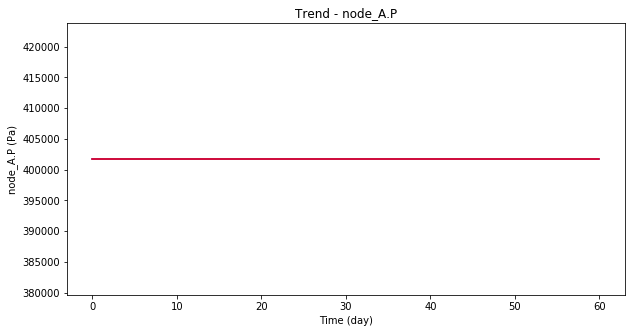

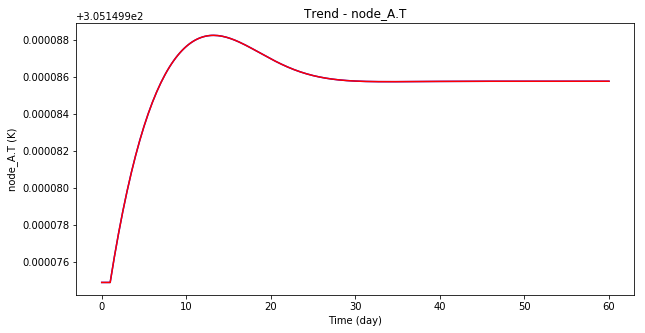

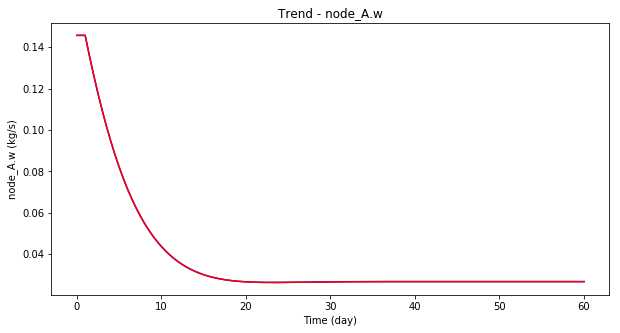

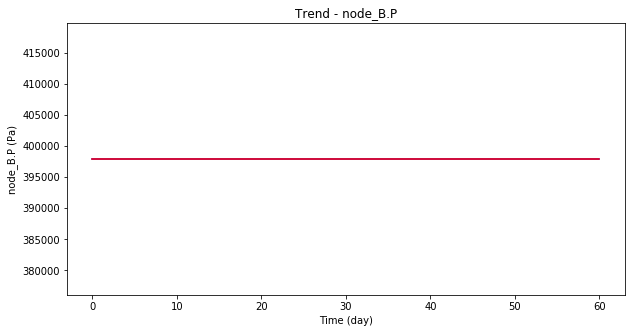

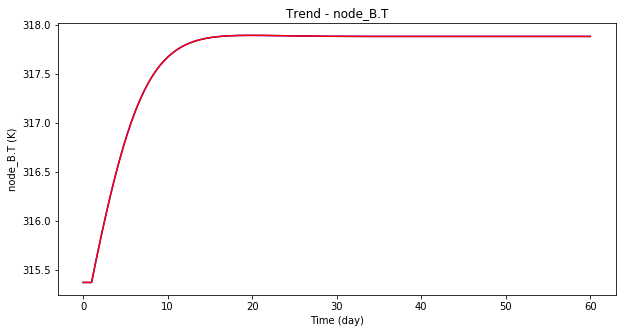

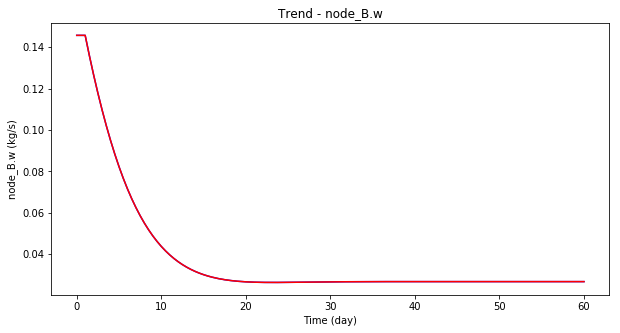

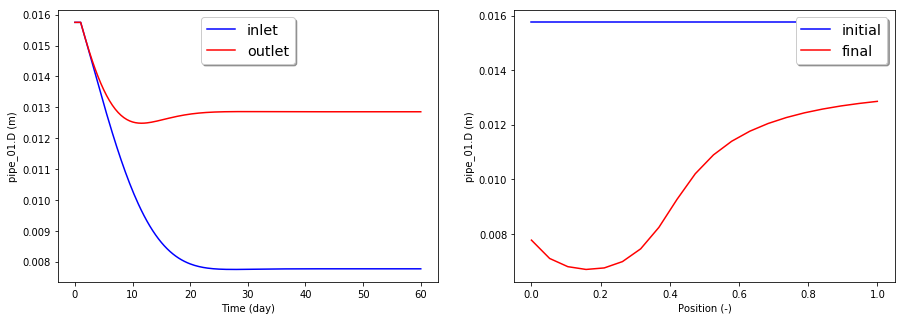

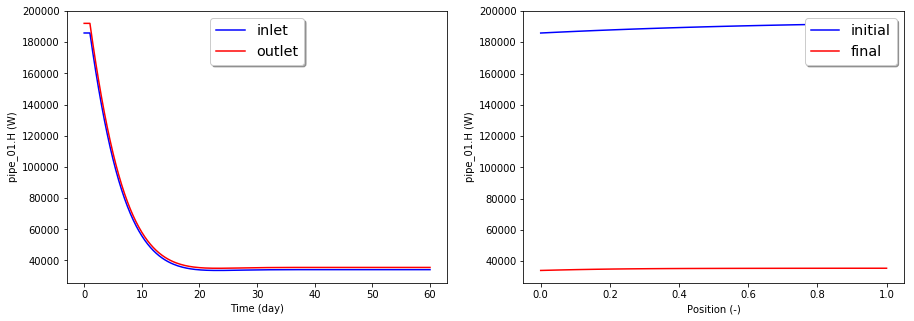

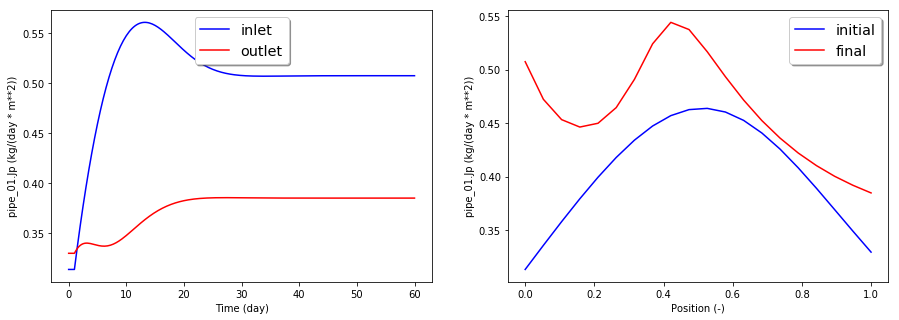

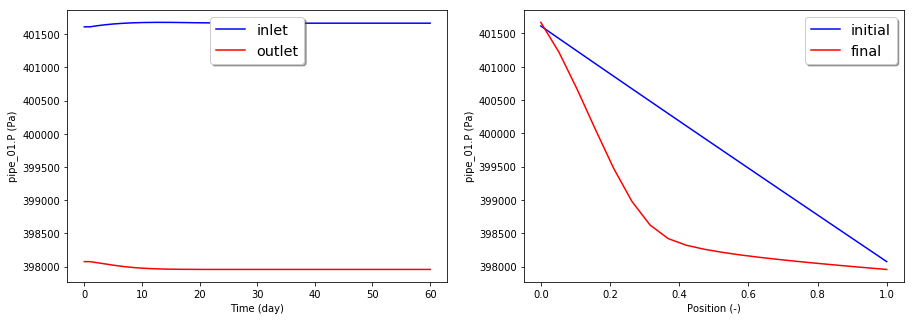

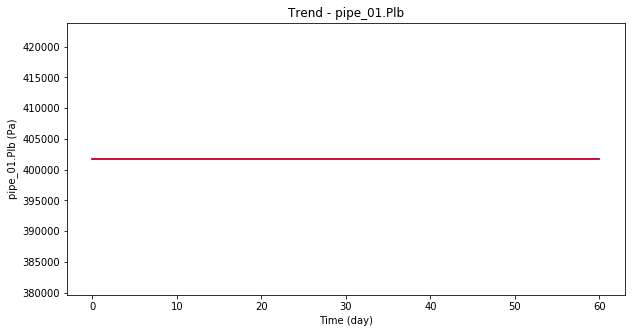

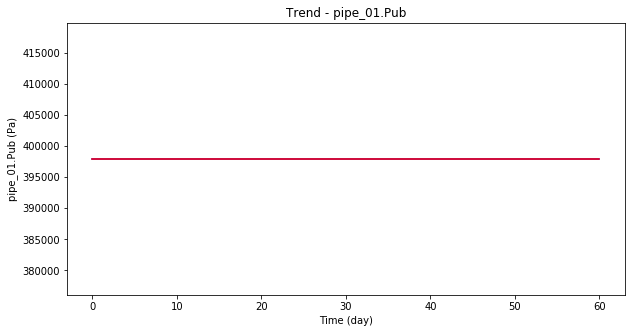

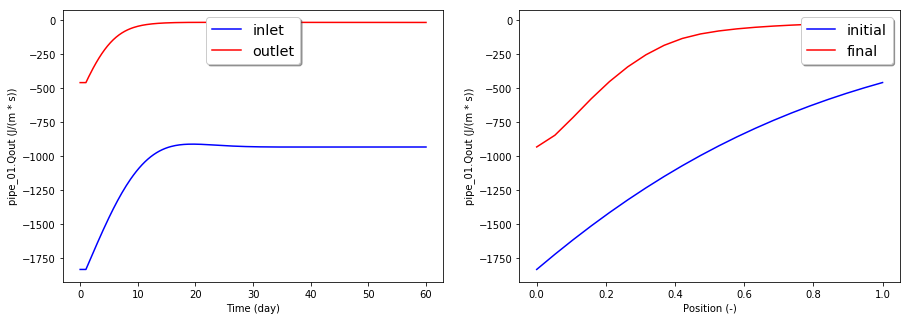

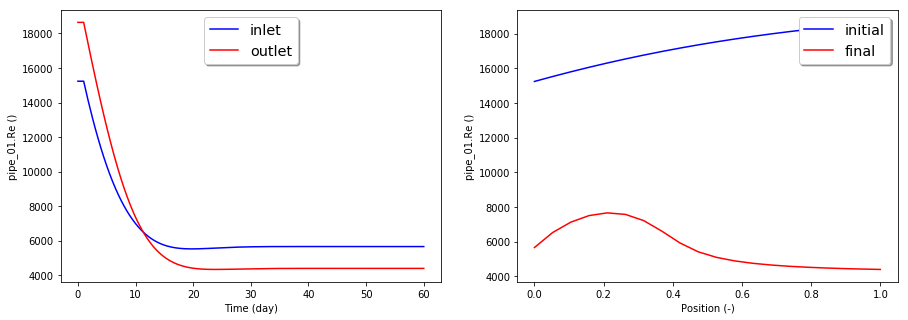

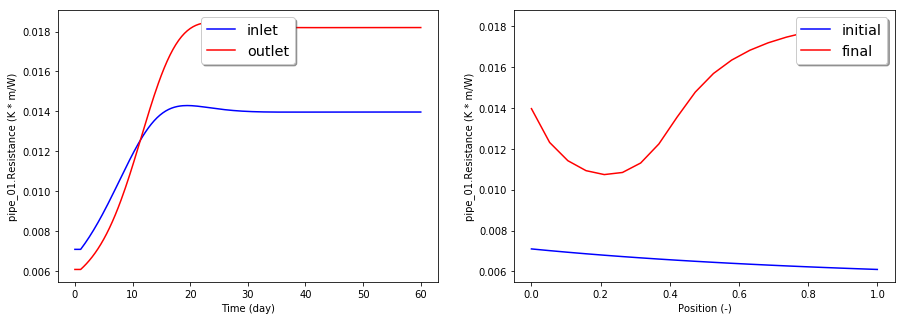

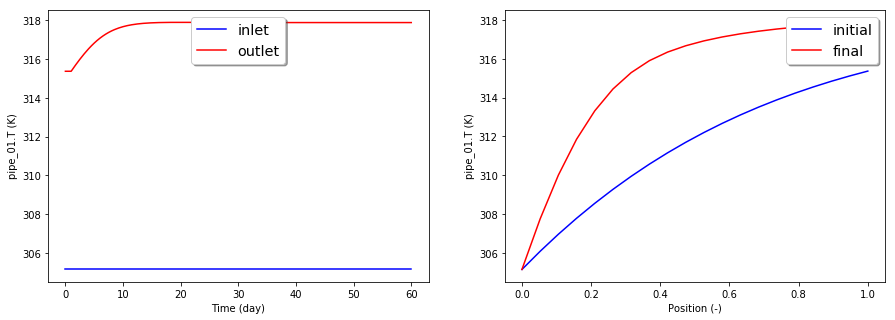

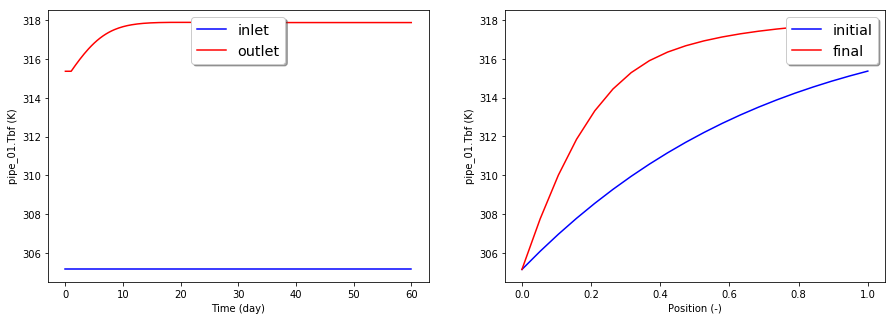

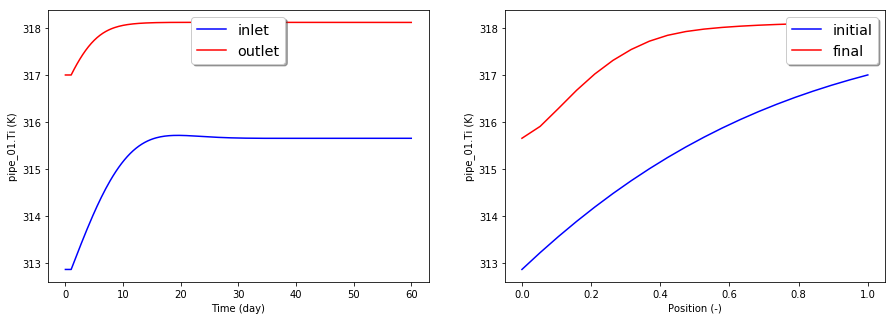

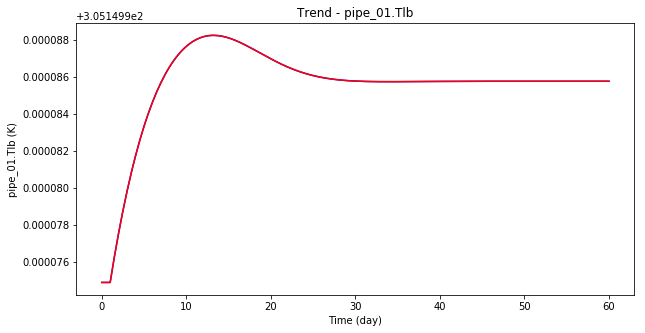

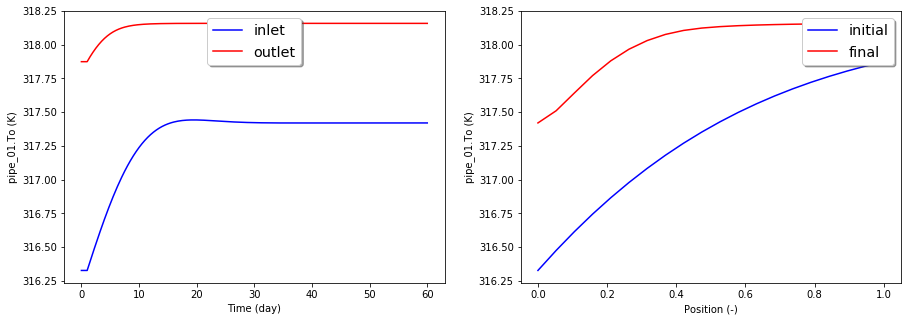

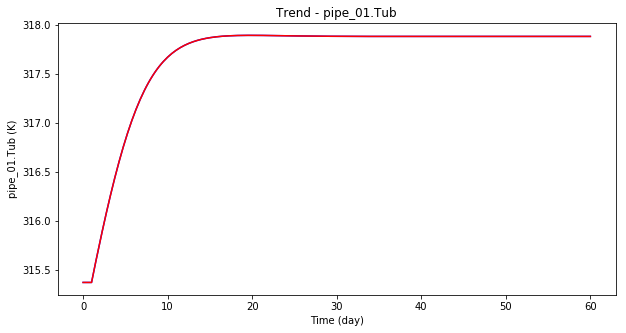

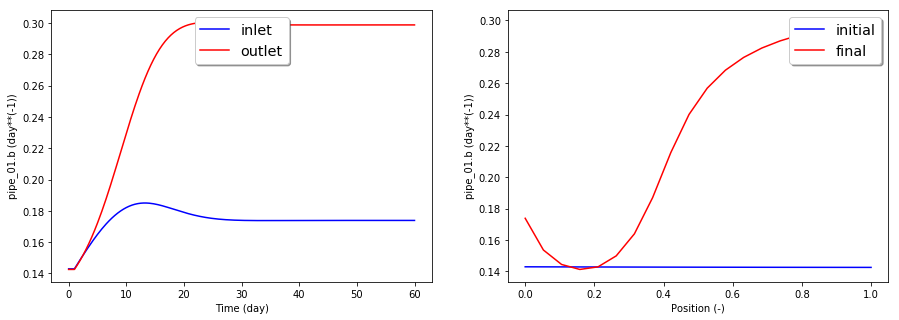

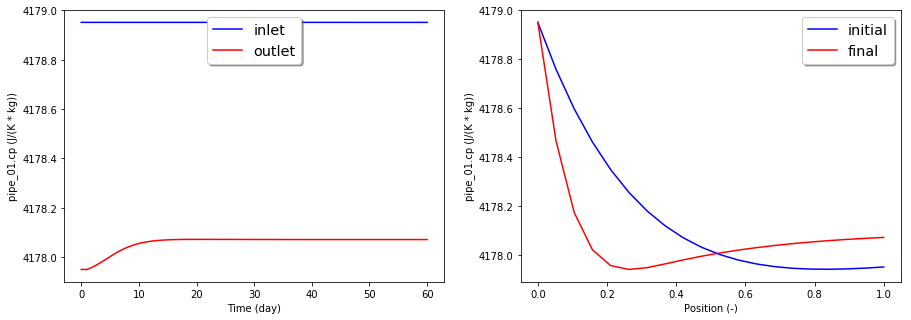

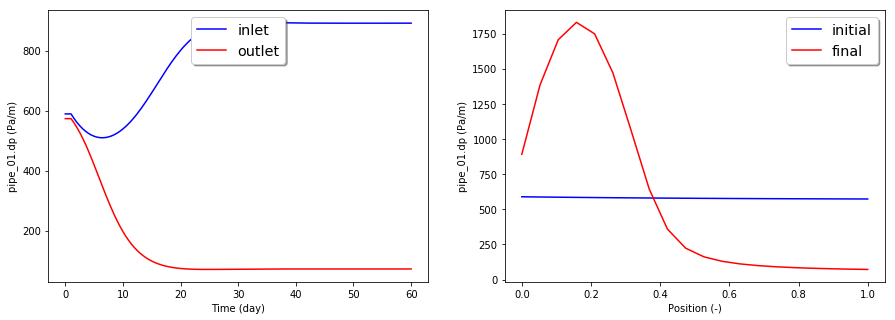

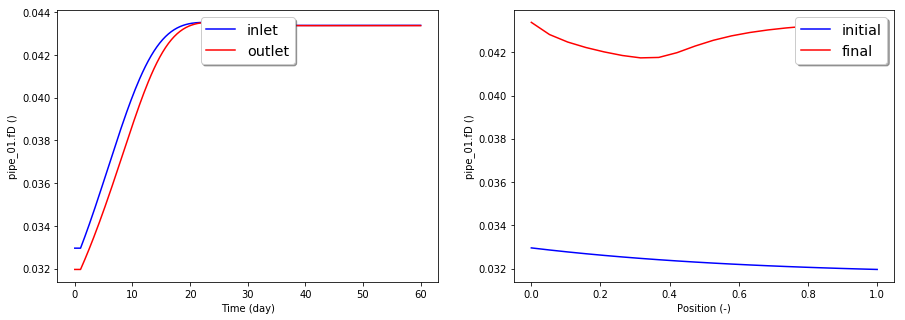

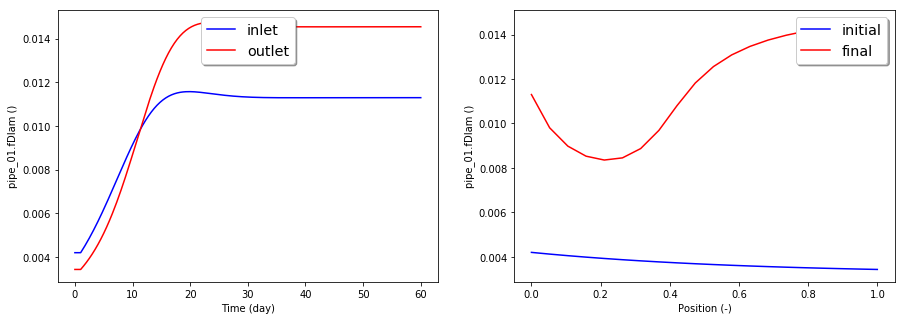

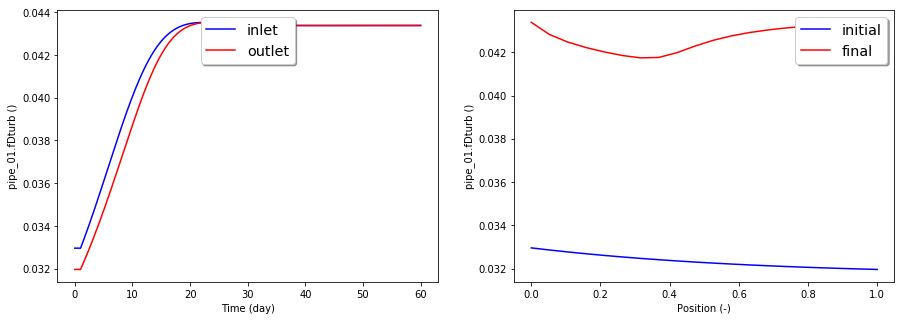

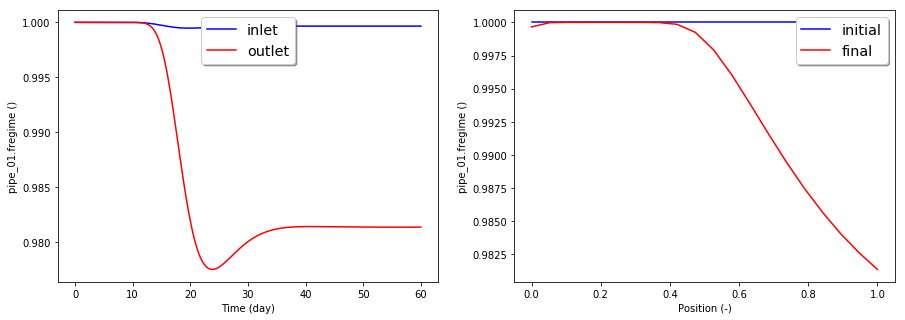

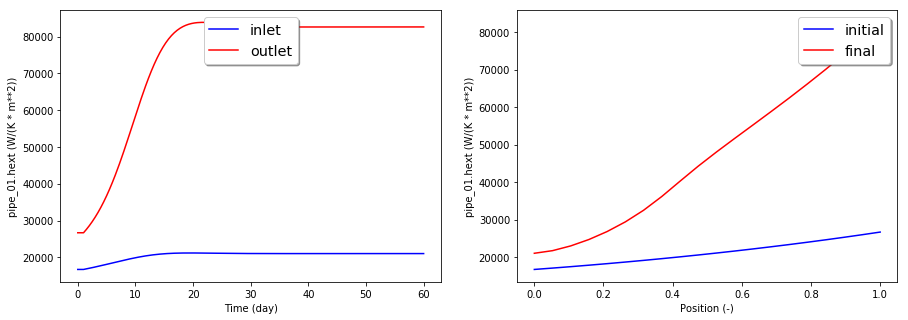

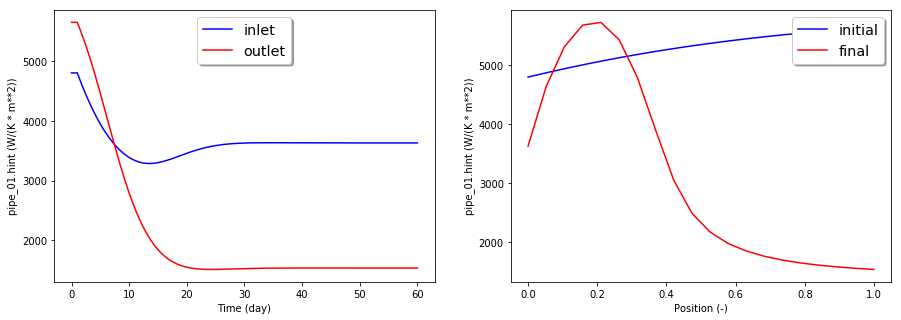

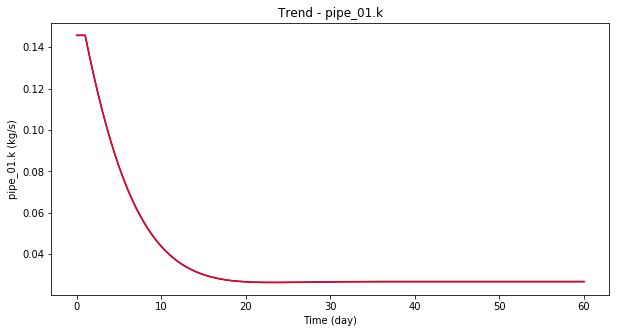

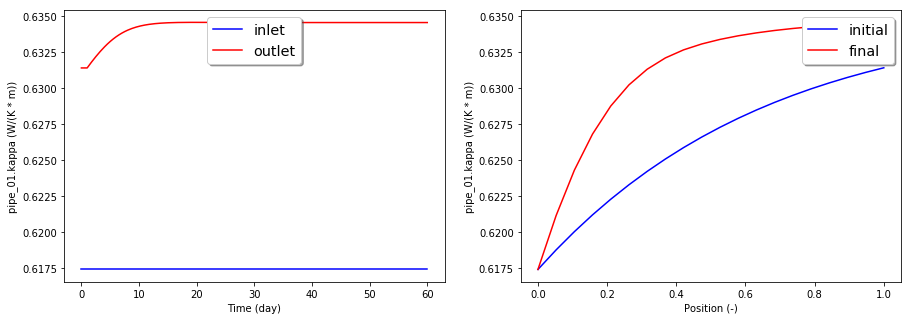

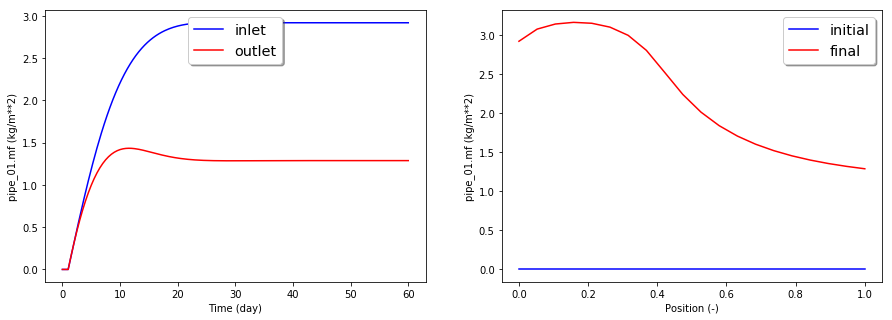

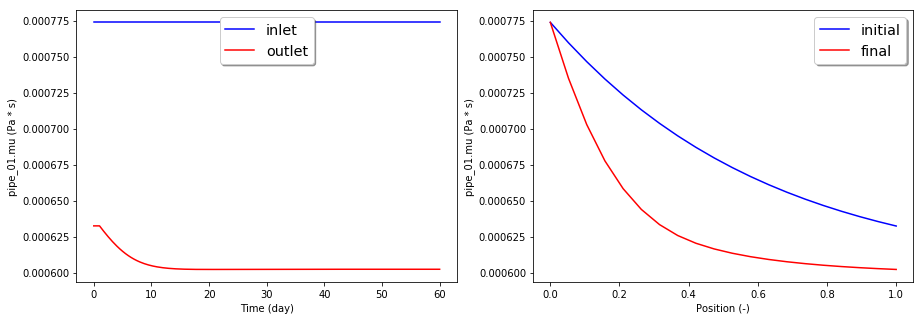

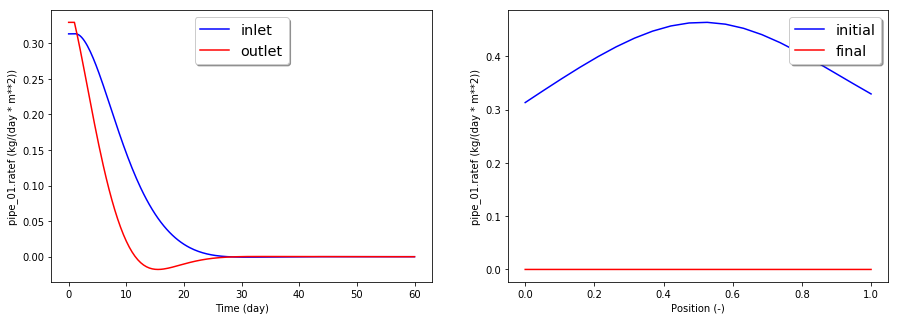

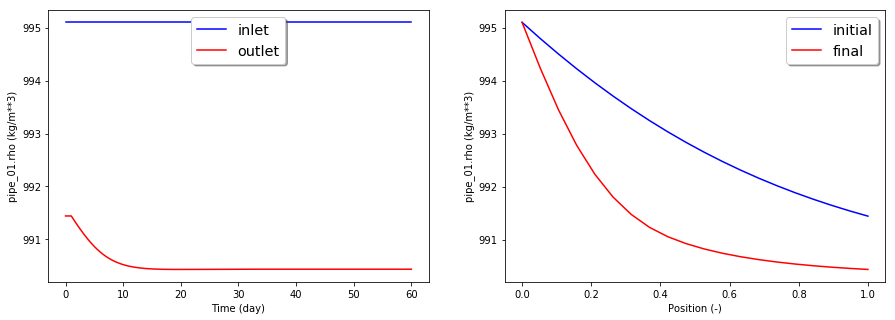

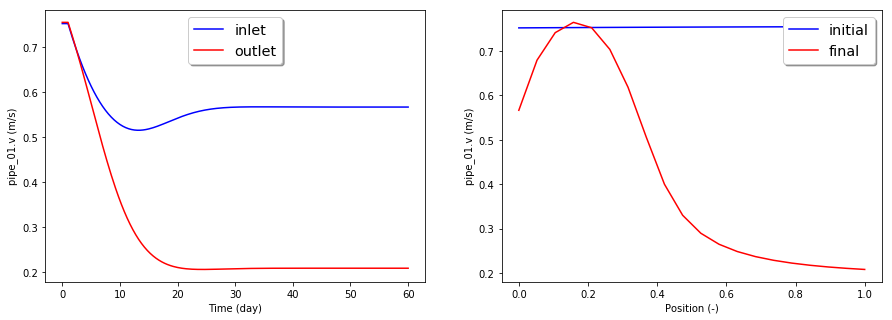

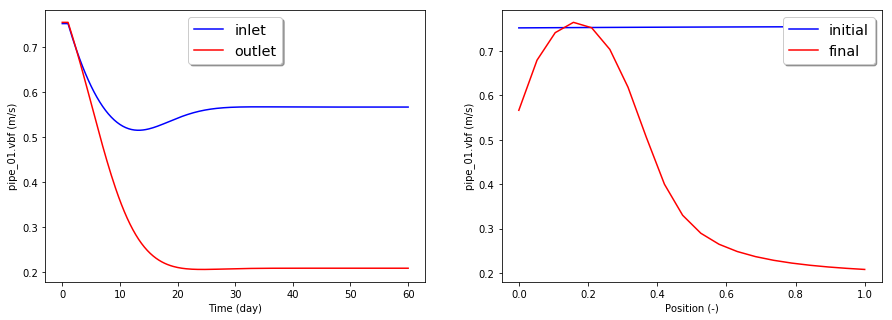

In [21]:
plot_dataframe(dr)